In [ ]:
import os
import sys

# Clone or pull part
repo_url = "https://github.com/fraco03/6D_pose.git"
repo_dir = "/kaggle/working/6D_pose"   #Modify here for kaggle
branch = "pose_Dense_Fusion"

# Clone if missing
if not os.path.exists(repo_dir):
    !git clone -b {branch} {repo_url}
    print(f"Cloned {repo_url} to {repo_dir}")
else:
    %cd {repo_dir}
    !git fetch origin
    !git checkout {branch}
    !git reset --hard origin/{branch}
    # %cd ..
    print(f"Updated {repo_url} to {repo_dir}")

# Add repository to Python path
if repo_dir not in sys.path:
    sys.path.insert(0, repo_dir)


Cloning into '6D_pose'...
remote: Enumerating objects: 659, done.
remote: Counting objects: 100% (325/325), done.
remote: Compressing objects: 100% (229/229), done.
remote: Total 659 (delta 183), reused 202 (delta 96), pack-reused 334 (from 1)
Receiving objects: 100% (659/659), 9.44 MiB | 29.02 MiB/s, done.
Resolving deltas: 100% (349/349), done.
Cloned https://github.com/fraco03/6D_pose.git to /kaggle/working/6D_pose


In [2]:
sys.path.insert(0,"/kaggle/working/6D_pose")

In [ ]:
%cd ..
!gdown --fuzzy https://drive.google.com/file/d/1zNthSyiBdPUfn7BmUKPbKoGgQdG1vGnS/view?usp=drive_link -O Linemod_preprocessed.zip
!unzip Linemod_preprocessed.zip
%cd 6D_pose

In [ ]:
from google.colab import drive
from utils.load_data import mount_drive

# Mounting part
mount_drive()

In [ ]:
%mv Linemod_preprocessed working/

In [3]:
# dataset_root = "/content/drive/MyDrive/Linemod_preprocessed" #Modify here for kaggle
# dataset_root = "../../Linemod_preprocessed_small"
# dataset_root = "/content/Linemod_preprocessed"
# dataset_root = "/kaggle/working/Linemod_preprocessed"
dataset_root = "/kaggle/input/line-mode/Linemod_preprocessed"

print("\n✅ Setup complete!")
print(f"📁 Dataset path: {dataset_root}")



✅ Setup complete!
📁 Dataset path: /kaggle/input/line-mode/Linemod_preprocessed


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%mv Linemod_preprocessed ./working

In [4]:
!pip install plyfile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.0 MB/s eta 0:00:00


In [ ]:
import sys

sys.path.append('../..')

In [ ]:
from src.dense_fusion.dataset import DenseFusionLineModDataset

train_dataset = DenseFusionLineModDataset(
    root_dir=dataset_root,
    split="train"
)

test_dataset = DenseFusionLineModDataset(
    root_dir=dataset_root,
    split="test"
)


✅ LineModConfig initialized: /kaggle/input/line-mode/Linemod_preprocessed
✅ Loaded PointNetLineModDataset
   Split: train (Ratio: 0.8)
   Num Points: 1024
   Total samples: 12634
✅ Loaded PointNetLineModDataset
   Split: test (Ratio: 0.8)
   Num Points: 1024
   Total samples: 3166


In [6]:
import torch
sample = train_dataset[0]

print(f"Sample keys: {sample.keys()}")
for key, value in sample.items():
    if isinstance(value, torch.Tensor):
        print(f"  {key}: Tensor of shape {value.shape} and dtype {value.dtype}")
    else:
        print(f"  {key}: {type(value)} with value {value}")

Sample keys: dict_keys(['points', 'centroid', 'rotation', 't_residual', 'gt_translation', 'object_id', 'class_idx', 'img_id', 'cam_K'])
  points: Tensor of shape torch.Size([3, 1024]) and dtype torch.float32
  centroid: Tensor of shape torch.Size([3]) and dtype torch.float32
  rotation: Tensor of shape torch.Size([4]) and dtype torch.float32
  t_residual: Tensor of shape torch.Size([3]) and dtype torch.float32
  gt_translation: Tensor of shape torch.Size([3]) and dtype torch.float32
  object_id: <class 'int'> with value 1
  class_idx: <class 'str'> with value ape
  img_id: <class 'int'> with value 987
  cam_K: Tensor of shape torch.Size([3, 3]) and dtype torch.float32


In [8]:
import torch

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
from utils.linemod_config import get_linemod_config
import numpy as np
import torch


linemod_config = get_linemod_config(dataset_root)

all_model_points = []
NUM_POINTS = 1000  # Number of points to sample from each model
VALID_OBJ_IDS = [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15] 
for obj_id in VALID_OBJ_IDS:
    model_points = linemod_config.get_model_3d(obj_id, unit='m')  # (N, 3)
    if model_points.shape[0] >= NUM_POINTS:
        choice = np.random.choice(model_points.shape[0], NUM_POINTS, replace=False)
    else:
        choice = np.random.choice(model_points.shape[0], NUM_POINTS, replace=True)
    model_points = model_points[choice, :]
    all_model_points.append(torch.tensor(model_points, dtype=torch.float32))
all_model_points = torch.stack(all_model_points, dim=0)  # (Num_Classes, NUM_POINTS, 3)
all_model_points = all_model_points.to(device)

max_obj_id = max(VALID_OBJ_IDS)

# Create a lookup table: obj_id -> index
obj_id_to_idx = torch.full((max_obj_id + 1,), -1, dtype=torch.long, device=device)
for idx, obj_id in enumerate(VALID_OBJ_IDS):
    obj_id_to_idx[obj_id] = idx


In [11]:
all_model_points.shape

torch.Size([13, 1000, 3])

In [ ]:
from src.dense_fusion.model import FusionPoseModel
import torch.nn as nn
from src.dense_fusion.model import PointNetPoseModel
from torch.optim import Adam, AdamW

model = FusionPoseModel(num_points=1024).to(device)

if torch.cuda.device_count() > 1:
    print(f"🔥 Using {torch.cuda.device_count()} GPU!")
    model = nn.DataParallel(model)

model = model.to(device)

# Loss function and optimizer
criterion = MultiObjectPointMatchingLoss(all_model_points)
optimizer = AdamW(
    model.parameters(), 
    lr=0.001, 
    betas=(0.9, 0.999), 
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=100,      # Imposta il numero delle tue epoche totali qui!
    eta_min=1e-5
)

🔥 Using 2 GPU!


In [13]:
def set_bn_momentum_default(curr_epoch, total_epochs, model):
    """
    Decade il momentum della Batch Norm da 0.1 a 0.01 seguendo una curva a step o coseno.
    In PyTorch il default momentum è 0.1.
    """
    # Formula originale PointNet: decade del 50% ogni tot step
    # Qui usiamo una versione coseno più moderna e fluida
    
    # Calcola il momentum target: parte da 0.1 e scende a 0.01
    start_mom = 0.1
    end_mom = 0.01
    
    # Interpolazione semplice basata sull'epoca
    momentum = end_mom + (start_mom - end_mom) * (1 - (curr_epoch / total_epochs))
    
    # Applica a tutti i layer di Batch Norm nel modello
    for m in model.modules():
        if isinstance(m, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d)):
            m.momentum = momentum

In [14]:
from torch.utils.data import DataLoader

batch_size = 128  #double GPU

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
from tqdm import tqdm
import os
import torch
from datetime import datetime

# ==========================================
# 0. SETUP AND CONFIGURATION
# ==========================================
num_epochs = 100  # PointNet converges relatively fast
best_test_loss = float('inf')
batch_size = 32  # Adjust based on your GPU VRAM

# Setup checkpoint directory
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
checkpoint_dir = f'/kaggle/working/DENSE_FUSION{timestamp}'
# checkpoint_dir = f'./DENSE_FUSION{timestamp}'
os.makedirs(checkpoint_dir, exist_ok=True)

# Trackers for plotting
train_losses = []
test_losses = []

print(f"🚀 Starting Dense Fusion Training on {device}")
print(f"📁 Checkpoints will be saved to: {checkpoint_dir}")
print(f"🗺️  Object ID Mapping created for {len(obj_id_to_idx)} objects.")

# ==========================================
# 1. TRAINING LOOP
# ==========================================
for epoch in range(num_epochs):
    set_bn_momentum_default(epoch, num_epochs, model)
    
    model.train()
    epoch_loss = 0.0

    # Initialize progress bar
    train_pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Training")
    
    for batch in train_pbar:
        # Move data to GPU
        # PointNet input: (Batch, 3, Num_Points)
        points = batch['points'].to(device)  

        # DenseFusion addiional input: images
        images = batch['images'].to(device)
        
        # Auxiliary data for reconstruction and loss
        centroids = batch['centroid'].to(device)       # (B, 3)
        gt_rotations = batch['rotation'].to(device)    # (B, 4)
        gt_t_absolute = batch['gt_translation'].to(device) # (B, 3) - Absolute target
        
        # Handle Object IDs for Loss Indexing
        raw_obj_ids = batch['object_id'].tolist()
        # Map raw IDs (e.g., 15) to buffer indices (e.g., 12)
        target_indices = torch.tensor(
            [obj_id_to_idx[oid] for oid in raw_obj_ids], 
            dtype=torch.long, device=device
        )

        # --- FORWARD PASS ---
        optimizer.zero_grad()
        
        # The network predicts: 
        # 1. Quaternion (pred_q)
        # 2. Residual Translation relative to centroid (pred_t_res)
        pred_q, pred_t_res = model(points, images)

        # --- RECONSTRUCTION ---
        # Reconstruct absolute translation for the ADD Loss
        # Absolute_Pos = Centroid + Residual
        pred_t_abs = centroids + pred_t_res

        # --- LOSS CALCULATION ---
        # Using MultiObjectPointMatchingLoss (ADD metric)
        loss = criterion(
            pred_q=pred_q, 
            pred_t=pred_t_abs,   # Pass the reconstructed absolute translation
            gt_q=gt_rotations, 
            gt_t=gt_t_absolute, 
            class_indices=target_indices
        )
        
        loss.backward()
        optimizer.step()

        # Update stats
        epoch_loss += loss.item()
        train_pbar.set_postfix({'ADD Loss (m)': f"{loss.item():.4f}"})

    # Calculate average training loss
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    scheduler.step()

    # ==========================================
    # 2. VALIDATION LOOP
    # ==========================================
    model.eval()
    test_loss = 0.0
    val_pbar = tqdm(test_loader, desc="Validating")
    
    with torch.no_grad():
        for batch in val_pbar:
            # Move data to GPU
            points = batch['points'].to(device)
            centroids = batch['centroid'].to(device)
            gt_rotations = batch['rotation'].to(device)
            gt_t_absolute = batch['gt_translation'].to(device)
            
            # Map IDs
            raw_obj_ids = batch['object_id'].tolist()
            target_indices = torch.tensor(
                [obj_id_to_idx[oid] for oid in raw_obj_ids], 
                dtype=torch.long, device=device
            )

            # Forward
            pred_q, pred_t_res = model(points)

            # Reconstruction
            pred_t_abs = centroids + pred_t_res

            # Loss
            loss = criterion(
                pred_q=pred_q, 
                pred_t=pred_t_abs, 
                gt_q=gt_rotations, 
                gt_t=gt_t_absolute, 
                class_indices=target_indices
            )
            
            test_loss += loss.item()
            val_pbar.set_postfix({'Val Loss': f"{loss.item():.4f}"})

    # Calculate average validation loss
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    print(f"📊 Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} m | Val Loss: {avg_test_loss:.4f} m")

    # ==========================================
    # 3. CHECKPOINT SAVING
    # ==========================================
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        checkpoint_path = os.path.join(checkpoint_dir, "best_model.pth")
        
        # Handle DataParallel state_dict if necessary
        model_state = model.module.state_dict() if isinstance(model, torch.nn.DataParallel) else model.state_dict()
        
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model_state,
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_test_loss,
            'config': { 
                'num_points': 1024, # Useful for inference
                'obj_map': obj_id_to_idx
            }
        }, checkpoint_path)
        print(f"✅ New Record! Model saved with Loss: {best_test_loss:.4f} m")
    else:
        print(f"⏳ No improvement (Best: {best_test_loss:.4f} m)")
    
    print("-" * 60)

In [ ]:
import matplotlib.pyplot as plt

# Create plots directory
# plots_dir = "plots"
plots_dir = checkpoint_dir
os.makedirs(plots_dir, exist_ok=True)

# Plot 1: Training vs Test Loss
plt.figure(figsize=(10, 6))
epochs_range = range(1, len(test_losses)+1)
plt.plot(range(1, len(train_losses)+1), train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
plt.plot(range(1, len(test_losses)+1), test_losses, 'r-s', label='Test Loss', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training vs Test Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
loss_plot_path = os.path.join(plots_dir, "loss_comparison.png")
plt.savefig(loss_plot_path, dpi=300, bbox_inches='tight')
print(f"✅ Plot saved: {loss_plot_path}")
plt.show()

# Plot 2: Only Training Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, 'b-o', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
train_loss_path = os.path.join(plots_dir, "training_loss.png")
plt.savefig(train_loss_path, dpi=300, bbox_inches='tight')
print(f"✅ Plot saved: {train_loss_path}")
plt.show()

# Plot 3: Only Test Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(test_losses)+1), test_losses, 'r-s', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.title('Test Loss Over Epochs', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=best_test_loss, color='g', linestyle='--', label=f'Best: {best_test_loss:.4f}', linewidth=2)
plt.legend(fontsize=11)
plt.tight_layout()
test_loss_path = os.path.join(plots_dir, "test_loss.png")
plt.savefig(test_loss_path, dpi=300, bbox_inches='tight')
print(f"✅ Plot saved: {test_loss_path}")
plt.show()

print(f"\n✅ All plots saved in '{plots_dir}' directory!")

In [ ]:
# Save losses
import pickle


losses_dict = {
    'train_losses': train_losses,
    'test_losses': test_losses
}

losses_path = os.path.join(checkpoint_dir, "losses.pkl")
with open(losses_path, 'wb') as f:
    pickle.dump(losses_dict, f)


# Visualize samples

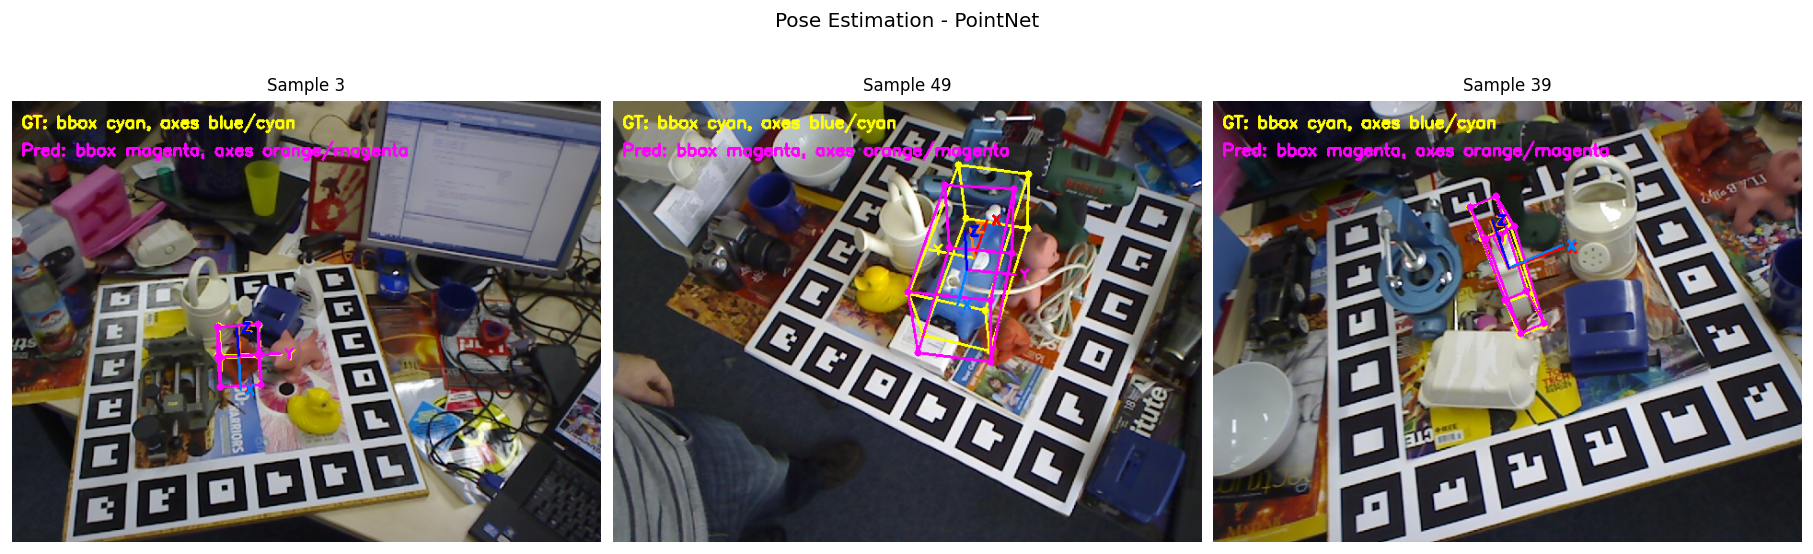

In [ ]:
from src.pose_pointnet.visualize import visualize_pointnet_random_samples
import torch

dataset_root = "../../Linemod_preprocessed_small"
checkpoint_path = "./DenseFusion_run/best_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


visualize_pointnet_random_samples(
    checkpoint_dir=checkpoint_path,
    dataset_root=dataset_root,
    device=device,
    num_samples=3
)


# Evaluation

In [1]:
import sys

sys.path.append("../..")

In [4]:
from src.pose_pointnet.evaluate import evaluate_POINTNET
MODEL_PATH = "./PointNet_final/best_model.pth"            # Path to the trained model
DATASET_ROOT = "../../Linemod_preprocessed"  # Path to the Linemod dataset
OUTPUT_PATH = "./PointNet_final/linemod_evaluation_report.csv"  # Path to save the evaluation report

evaluate_POINTNET(
    model_path=MODEL_PATH,
    dataset_root=DATASET_ROOT,
    output_path=OUTPUT_PATH
)

📥 Loading 3D model points and diameters...
📦 Loading trained model...
📚 Preparing test dataset and dataloader...
✅ Loaded PointNetLineModDataset
   Split: test (Ratio: 0.8)
   Num Points: 1024
   Total samples: 3166

🚀 Starting Comprehensive Benchmark (ADD Error + ADD-0.1d Accuracy)...


Evaluating: 100%|██████████| 25/25 [04:05<00:00,  9.81s/batch]


📊 Evaluation report saved to ./PointNet_final/linemod_evaluation_report.csv


,Object ID,Object Name,Diameter (mm),Mean ADD (mm),Mean ADD-S (mm),Mean ADD-Rot (mm),Mean ADD-S-Rot (mm),ADD-0.1d Accuracy (%),ADD-S-0.1d Accuracy (%)
0,1,ape,102.098657,6.679966,2.037890,6.679965,2.037879,81.048387,99.596774
1,2,benchvise,247.506242,8.100433,3.681120,8.100749,3.681319,96.707819,100.000000
2,4,camera,172.492249,6.716697,2.635545,6.716963,2.635681,97.925311,100.000000
3,5,can,201.403586,8.217553,2.867360,8.217713,2.867559,93.750000,100.000000
4,6,cat,154.545518,4.936058,2.210730,4.936169,2.210805,98.728814,100.000000
5,8,driller,261.471781,8.412135,4.028226,8.412293,4.028470,97.058824,99.579832
6,9,duck,108.999201,6.542511,2.149380,6.542627,2.149458,90.039841,99.601594
7,10,eggbox,164.627588,14.211834,3.305134,14.211831,3.305131,83.266932,100.000000
8,11,glue,175.889334,7.706465,3.170037,7.706610,3.170126,93.442623,100.000000
9,12,holepuncher,145.542875,7.005216,2.410881,7.005245,2.410899,95.161290,100.000000
